In [29]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [30]:
train_dataset = torchvision.datasets.FashionMNIST(
    root = '.',
    train = True,
    transform = transforms.ToTensor(),
    download = True
)

In [31]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [32]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [33]:
test_dataset = torchvision.datasets.FashionMNIST(
    root = '.',
    train = False,
    transform = transforms.ToTensor(),
    download = True
)

In [34]:
#number of classes
K = len(set(train_dataset.targets.numpy()))
print(f'Number of classes: {K}')

Number of classes: 10


In [248]:
#Define model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
        nn.ReLU(),
    )

    self.dense_layers = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(128 * 2 * 2, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, K),
    )

  def forward(self, X):
    out = self.conv_layers(X),
    out = out[0].view(out[0].size(0),  -1),
    out = self.dense_layers(out[0])
    return out

In [249]:
#Instantiate the model
model = CNN(K)

In [250]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [251]:
#Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [252]:
#Data Loader
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = False)

In [253]:
#Function to encapsulate the training loop
def  batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()

      #Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      #Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    #Get train loss and test loss
    train_loss = np.mean(train_loss)

    model.eval()
    test_loss = []

    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      #Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())

    test_loss = np.mean(test_loss)

    #Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs},  Train Loss: {train_loss:.4f}, \
    Test Loss: {test_loss:.4f}, Duration: {dt} ')
  return train_losses, test_losses


In [254]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=15
)

Epoch 1/15,  Train Loss: 0.6703,     Test Loss: 0.5047, Duration: 0:00:10.904165 
Epoch 2/15,  Train Loss: 0.4510,     Test Loss: 0.4282, Duration: 0:00:10.041014 
Epoch 3/15,  Train Loss: 0.3926,     Test Loss: 0.3928, Duration: 0:00:09.633533 
Epoch 4/15,  Train Loss: 0.3583,     Test Loss: 0.3577, Duration: 0:00:10.270323 
Epoch 5/15,  Train Loss: 0.3299,     Test Loss: 0.3404, Duration: 0:00:10.302257 
Epoch 6/15,  Train Loss: 0.3089,     Test Loss: 0.3230, Duration: 0:00:10.369673 
Epoch 7/15,  Train Loss: 0.2920,     Test Loss: 0.3117, Duration: 0:00:09.646441 
Epoch 8/15,  Train Loss: 0.2745,     Test Loss: 0.3205, Duration: 0:00:10.312121 
Epoch 9/15,  Train Loss: 0.2627,     Test Loss: 0.3058, Duration: 0:00:10.488156 
Epoch 10/15,  Train Loss: 0.2477,     Test Loss: 0.3057, Duration: 0:00:10.433860 
Epoch 11/15,  Train Loss: 0.2325,     Test Loss: 0.3001, Duration: 0:00:10.228346 
Epoch 12/15,  Train Loss: 0.2226,     Test Loss: 0.2903, Duration: 0:00:09.646468 
Epoch 13/15, 

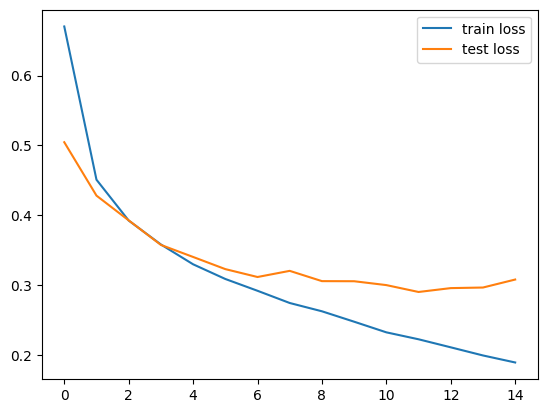

In [255]:
#Plot th train loss and test loss per iteration
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.legend()
plt.show()

In [256]:
#Accuracy
model.eval()
n_correct = 0.
n_total = 0.

for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0
n_total = 0

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9470, Test acc: 0.8954


In [ ]:
#Label mapping
labels = """ T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot
""".split('\n')